<font size=3> **Goal:** The purpose of this notebook is to analyze the results after doing equilibration procedure on the full one square degree and compare them to previous results, see if we can proceed to money plot, etc. </font>

# Preamble

In [1]:
import os
from importlib import reload
os.chdir('/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/WLD')

%matplotlib inline 

import mycode
reload(mycode);

In [2]:
from mycode import money
from mycode import preamble
from mycode import weights 
from mycode import maps 

from tqdm import tqdm 

%run mycode/preamble.py

reload(weights)
reload(preamble)
reload(maps)
reload(money);

In [3]:
import astroML
import subprocess
from astroML.plotting import scatter_contour

In [4]:
from astropy.table import Table

In [5]:
data_dir = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/WLD/data'

## Read catalogues

In [6]:
#filters to apply as reading the catalogue. 
pfilters = [
    maps.get_non_duplicated_cat
]

#filters to be applied uniformly ignoring the selection effect. 
afilters=[
    maps.get_not_dropped_cat, #does not commute with the other ones, so do first. 
    maps.not_dropped, #redundant. 
    maps.low_cond,
]


ffilters = [
    maps.good, 
    maps.best,
]

### testing 

In [7]:
pcat1, pcat2 = (Table.read(f"{data_dir}/projectLSST-g1_0-g2_0/final_fits.fits"), 
            Table.read(f"{data_dir}/projectLSST-g1_20-g2_0/final_fits.fits"))

pfcat1, pfcat2 = (Table.read(f"{data_dir}/fprojectLSST-g1_0-g2_0/final_fits.fits"), 
            Table.read(f"{data_dir}/fprojectLSST-g1_20-g2_0/final_fits.fits"))

In [8]:
cat1, cat2 = maps.get_filter_cats([pcat1, pcat2], pfilters) 
fcat1, fcat2 = maps.get_filter_cats([pfcat1, pfcat2], pfilters) 

#check lengths. 
print(len(cat1), len(cat2))
print(len(fcat1), len(fcat2))

802101 802031
802101 802031


In [9]:
scat1, scat2 = maps.get_filter_cats([cat1, cat2], afilters)

scat1 = maps.get_filter_cats([scat1], ffilters)[0]
print(len(scat1))

#remember to not apply filters directly on cat2, but intersect
scat1, scat2 = maps.get_intersection_cats([scat1, scat2]) 
print(len(scat1),len(scat2))

77718
77244 77244


In [10]:
fscat1, fscat2 = maps.get_filter_cats([fcat1, fcat2], afilters)


fscat1 = maps.get_filter_cats([fscat1], ffilters)[0]
print(len(fscat1))

#remember to not apply filters directly on cat2, but intersect
fscat1, fscat2 = maps.get_intersection_cats([fscat1, fscat2]) 
print(len(fscat1),len(fscat2))

112840
112701 112701


### read all 

In [7]:
pcats = [
        Table.read(f"{data_dir}/fprojectLSST-g1_-20-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_-15-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_-10-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_-5-g2_0/final_fits.fits"),
        Table.read(f"{data_dir}/fprojectLSST-g1_0-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_5-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_10-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_15-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_20-g2_0/final_fits.fits")
        ]

In [8]:
cats = maps.get_filter_cats(pcats, pfilters) 
[len(cat) for cat in cats]

[802149, 802075, 802121, 802182, 802101, 802074, 802166, 802013, 802031]

In [9]:
# scats = maps.get_filter_cats(cats, afilters)
# [len(cat) for cat in scats]

In [10]:
# fcat1 = maps.get_filter_cats([scats[4]], ffilters)[0]
# print(len(fcat1))
# scats.pop(4)
# scats.insert(4, fcat1) 
# print(len(scats))

In [11]:
# #remember to not apply filters directly on cat2, but intersect
# fcats = maps.get_intersection_cats(scats)

# [len(cat) for cat in fcats]

In [12]:
# subprocess.run("mkdir data/fcats", shell=True)
# for i,cat in enumerate(fcats): 
#     cat.write( f"data/fcats/fcat{i}.fits", "fits" )
    

In [13]:
fcats = [Table.read( f"data/fcats/fcat{i}.fits") for i in range(9)]
[len(cat) for cat in fcats]

[112574, 112574, 112574, 112574, 112574, 112574, 112574, 112574, 112574]

# Condition numbers

In [31]:
conds1 = np.log10(cat1[(fcat1['cond_num_grp'] < 1e20) & (cat1['cond_num_grp'] < 1e20)]['cond_num_grp'])
conds2 = np.log10(fcat1[(fcat1['cond_num_grp'] < 1e20) & (cat1['cond_num_grp'] < 1e20)]['cond_num_grp'])

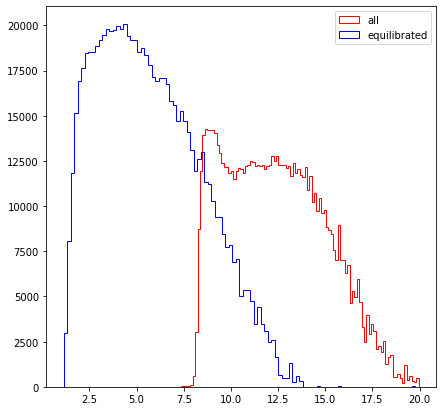

In [32]:
plt.figure(figsize=(7,7))
plt.hist(conds1, bins=100, color='red', 
         histtype='step', label='all');
plt.hist(conds2, bins=100, color='blue' ,
         histtype='step', label='equilibrated');
plt.legend()

<font size=3> **Note:** No significant difference found for the histograms in the case of applied shear case </font>

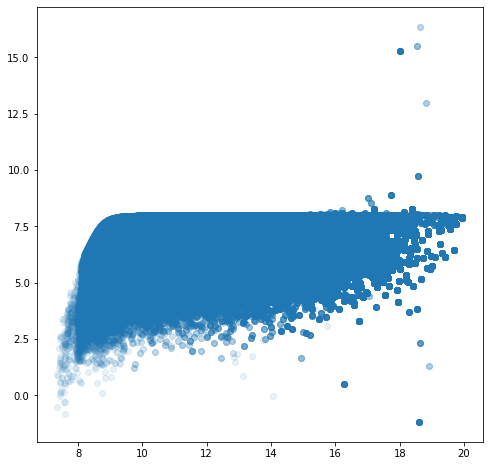

In [33]:
plt.figure(figsize=(8,8))
plt.scatter(conds1, conds1 - conds2, alpha=0.1)

## condition number vs. bias

In [60]:
#selection cuts 
temp1 = fcats[4]
cond = (temp1['cond_num'] < np.inf) & (temp1['bias_g1_grp']  != 0) & (temp1['cond_num_grp'] < np.inf)
cond_num_iso = np.log10(temp1[cond]['cond_num'])
cond_num_grp = np.log10(temp1[cond]['cond_num_grp'])
bias_iso = np.log10(np.absolute(temp1[cond]['bias_g1']))
bias_grp = np.log10(np.absolute(temp1[cond]['bias_g1_grp']))

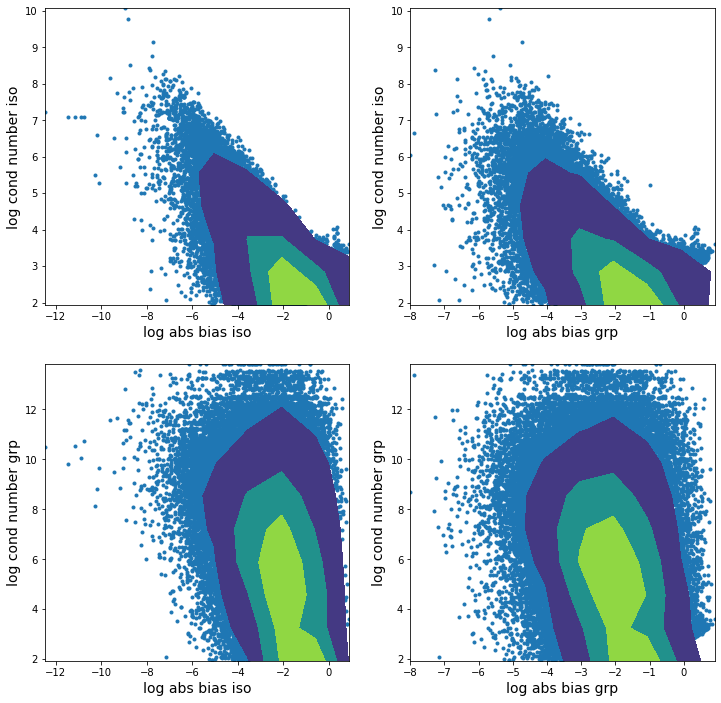

In [61]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(12,12))
axes = axs.flatten()
num_points = len(bias_iso)

scatter_contour(bias_iso, cond_num_iso, ax=axes[0], levels=4, threshold=num_points/100)
axes[0].set_xlabel("log abs bias iso", size=14); 
axes[0].set_ylabel("log cond number iso", size=14)


scatter_contour(bias_grp, cond_num_iso, ax=axes[1], levels=4, threshold=num_points/100)
axes[1].set_xlabel("log abs bias grp", size=14); 
axes[1].set_ylabel("log cond number iso", size=14)


scatter_contour(bias_iso, cond_num_grp, ax=axes[2], levels=4, threshold=num_points/100)
axes[2].set_xlabel("log abs bias iso", size=14); 
axes[2].set_ylabel("log cond number grp", size=14)
axes[2].set_ylim()

scatter_contour(bias_grp, cond_num_grp, ax=axes[3], levels=4, threshold=num_points/100)
axes[3].set_xlabel("log abs bias grp", size=14); 
axes[3].set_ylabel("log cond number grp", size=14);


# Weighting

In [77]:
def weights_bias_scatter(ax, cat, component, iso_or_grp, xlabel=None, title=None, xlim=(-5,5), size_dots=0.5, alpha=1): 
    orig_ids = list(range(len(cat)))
    ws = weights.get_weights(orig_ids, cat,  component, iso_or_grp, 'component')
    suffix = weights.get_iso_or_grp_suffix(iso_or_grp)

    ax.scatter(cat[f'bias_g{component}{suffix}'], ws, alpha=alpha, s=size_dots, c='b')
    ax.set_title(title, size = 18 )
    ax.set_xlabel(xlabel, size=18)
    ax.set_ylabel('Weights', size=18)
    ax.set_xlim(xlim)

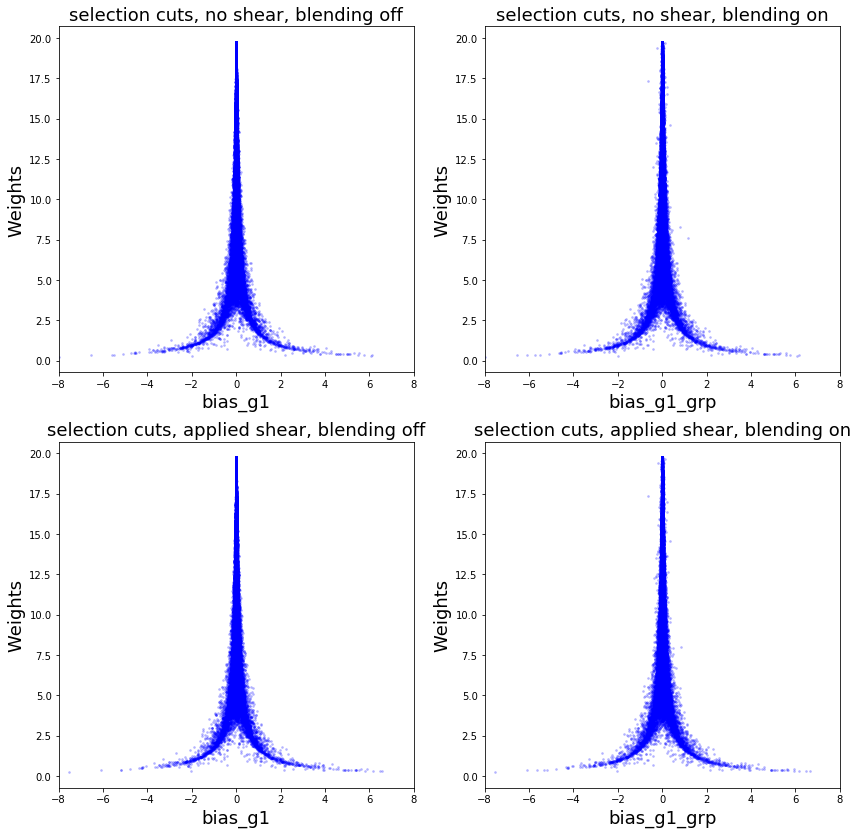

In [88]:
fig, axs = plt.subplots(2,2,figsize=(14,14))
axes = axs.flatten()
weights_bias_scatter(axes[0], fscat1, '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="bias_g1", title="selection cuts, no shear, blending off")

weights_bias_scatter(axes[1], fscat1, '1', 'grp', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="bias_g1_grp", title="selection cuts, no shear, blending on")

weights_bias_scatter(axes[2], fscat2, '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="bias_g1", title="selection cuts, applied shear, blending off")

weights_bias_scatter(axes[3], fscat2, '1', 'grp', xlim=[-8,8], size_dots=3, alpha=0.2,
                     xlabel="bias_g1_grp", title="selection cuts, applied shear, blending on")

## outliers?

In [97]:
ws_grp = weights.get_weights(list(range(len(fscat1))), fscat1, '1', 'grp', which_shape_noise='component')
cond1 = (ws_grp> 10)
cond2 = (np.absolute(fscat1['bias_g1_grp']) > 0.5 )
fscat1[cond1 & cond2]

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,cond_num,cond_num_grp,bias_f,bias_s,bias_g1,bias_g2,bias_x,bias_y,bias_f_grp,bias_s_grp,bias_g1_grp,bias_g2_grp,bias_x_grp,bias_y_grp,match,ambig_blend
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bool
402702075926,402702075926,3,0,1,5943,5962,5480,5498,0.99134684,0.008653155,-609.43994,17.889114,1.0604616,24.39512,0.3437271,124136.45,0.43053705,0.4393904,0.058692172,-0.13002834,0.4970418,0.3729307,-0.57339776,0.75692636,0.9873779,28.92598,28.780598,28.780264,18.337465,16.47349,0.08965598,0.07731721,0.08001852,0.09715037,0.08370334,0.08586125,825.73145,21801672.0,367.09695,-0.007279529,0.001445069,-0.003193984,-7.566406e-07,3.6597818e-08,-57492.523,-0.58481675,-0.6242049,0.20370696,0.22936146,-0.06164475,139,False


In [98]:
ws_grp = weights.get_weights(list(range(len(fscat2))), fscat2, '1', 'grp', which_shape_noise='component')
cond1 = (ws_grp> 10)
cond2 = (np.absolute(fscat2['bias_g1_grp']) > 0.5 )
fscat2[cond1 & cond2]

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,cond_num,cond_num_grp,bias_f,bias_s,bias_g1,bias_g2,bias_x,bias_y,bias_f_grp,bias_s_grp,bias_g1_grp,bias_g2_grp,bias_x_grp,bias_y_grp,match,ambig_blend
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bool
402702075926,402702075926,3,0,1,5942,5962,5480,5498,0.99134684,0.008653155,-609.43994,17.889114,1.0604616,24.39512,0.3437271,124136.45,0.43062317,0.44066414,0.07893673,-0.12967084,0.50181097,0.3695342,-0.51198506,0.7574357,0.9869617,28.908684,28.763556,28.763206,18.330292,16.399374,0.08991309,0.07755667,0.079949714,0.09748346,0.08401786,0.08603185,831.5201,22438136.0,366.8613,-0.007342352,0.0016937036,-0.0032032984,-4.980489e-07,-1.0122217e-07,-58379.055,-0.5790645,-0.6262154,0.20624898,0.23626676,-0.061974607,138,False


## outliers in other catalogues? 


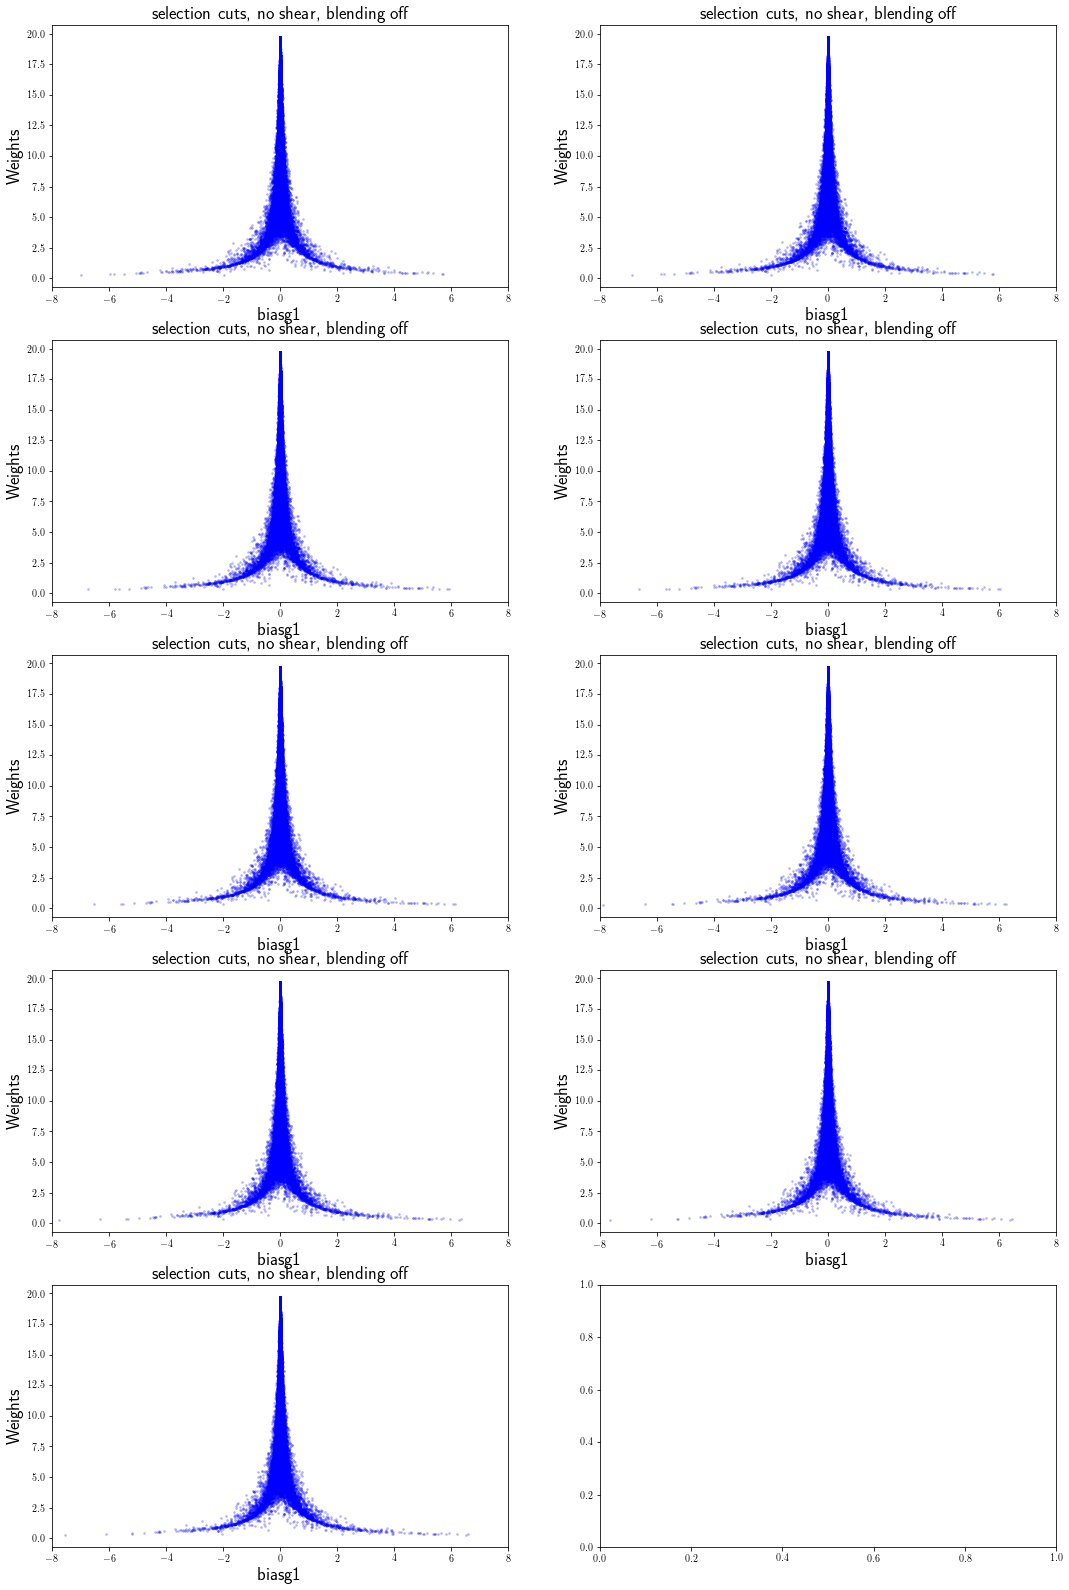

In [86]:
fig, axs = plt.subplots(5,2,figsize=(18,28))
axes = axs.flatten()
weights_bias_scatter(axes[0], fcats[0], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")
weights_bias_scatter(axes[1], fcats[1], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")
weights_bias_scatter(axes[2], fcats[2], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")
weights_bias_scatter(axes[3], fcats[3], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")
weights_bias_scatter(axes[4], fcats[4], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")
weights_bias_scatter(axes[5], fcats[5], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")
weights_bias_scatter(axes[6], fcats[6], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")
weights_bias_scatter(axes[7], fcats[7], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")
weights_bias_scatter(axes[8], fcats[8], '1', 'iso', xlim=[-8,8], size_dots=3, alpha=0.2, 
                     xlabel="biasg1", title="selection cuts, no shear, blending off")

# comparisons with old catalogue

## all catalogue

In [11]:
ccat2, cfcat2 = maps.get_intersection_cats([cat2, fcat2])
print(len(ccat2))
print(len(cfcat2))

802031
802031


(0, 1000.0)

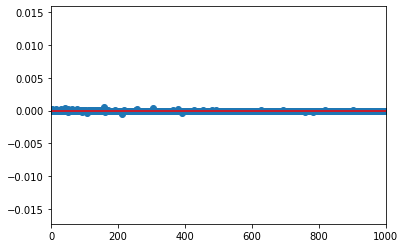

In [12]:
plt.scatter(ccat2['snr_grpf'], cfcat2['snr_grpf']-ccat2['snr_grpf'])
plt.plot([0, 1e5], [0, 0], c='r')
plt.xlim(0,1e3)

In [13]:
cond = ccat2['snr_grpf'] > 0 
fcond = cfcat2['snr_grpf'] > 0 
np.max( np.absolute(cfcat2[fcond]['snr_grpf']-ccat2[cond]['snr_grpf']) / ccat2[cond]['snr_grpf'])

0.00033703435

In [15]:
np.max( np.absolute(cfcat2[fcond]['dg1_grp']-ccat2[cond]['dg1_grp']) / ccat2[cond]['dg1_grp'])

0.000213664

1.3018836


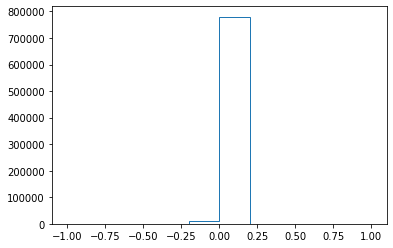

In [24]:
# xs = np.ma.log10(np.absolute(ccat2[cond]['bias_g1_grp']))
ys = np.ma.log10( (np.absolute(cfcat2[fcond]['bias_g1_grp']-ccat2[cond]['bias_g1_grp']))/ccat2[cond]['bias_g1_grp'])

plt.hist(ys,  histtype='step', range=[-1,1]);
print(np.max(ys))
# 1e5], [0, 0], c='r')
# plt.xlim(-6,6)


In [108]:
cond = ccat2['snr_grpf'] > 0 
fcond = cfcat2['snr_grpf'] > 0 
np.max( np.absolute(cfcat2[fcond]['bias_g1_grp']-ccat2[cond]['bias_g1_grp']) / ccat2[cond]['bias_g1_grp'])

20.039349

## selected catalogues

In [25]:
cscat2, cfscat2 = maps.get_intersection_cats([scat2, fscat2])
print(len(cscat2))
print(len(cfscat2))

75323
75323


In [26]:
cond = cscat2['snr_grpf'] > 0 
fcond = cfscat2['snr_grpf'] > 0 
np.max( np.absolute(cfscat2[fcond]['bias_g1_grp']-cscat2[cond]['bias_g1_grp']) / cscat2[cond]['bias_g1_grp'])

0.25136

# Bias histograms

## general

Text(0.5, 1.0, 'selection cuts')

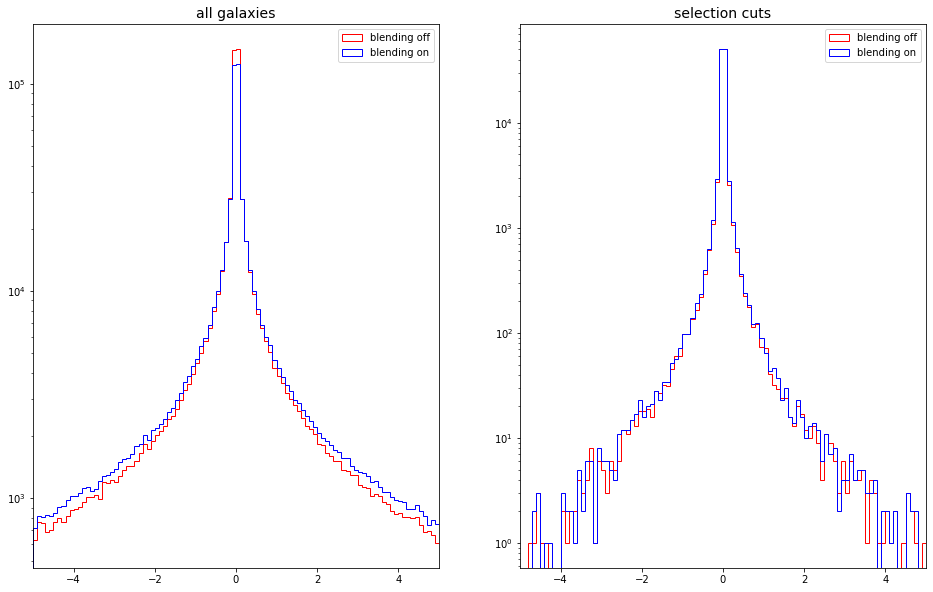

In [21]:
cat1 = cats[4]
cat2 = fcats[4]

fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(16,10))
ax1,ax2 = axs.flatten()

ax1.hist(cat1['bias_g1'], histtype='step', range=[-5,5], bins=100, label='blending off', color='r')
ax1.hist(cat1['bias_g1_grp'], histtype='step', range=[-5,5], bins=100, label='blending on', color='b');
ax1.legend()
ax1.set_xlim(-5,5)
ax1.set_yscale("log")
ax1.set_title("all galaxies", fontsize=14)

ax2.hist(cat2['bias_g1'], histtype='step', range=[-5,5], bins=100, label='blending off', color='r')
ax2.hist(cat2['bias_g1_grp'], histtype='step', range=[-5,5], bins=100, label='blending on', color='b');
ax2.legend()
ax2.set_xlim(-5,5)
ax2.set_yscale("log")
ax2.set_title("selection cuts", fontsize=14)

Text(0.5, 1.0, 'selection cuts')

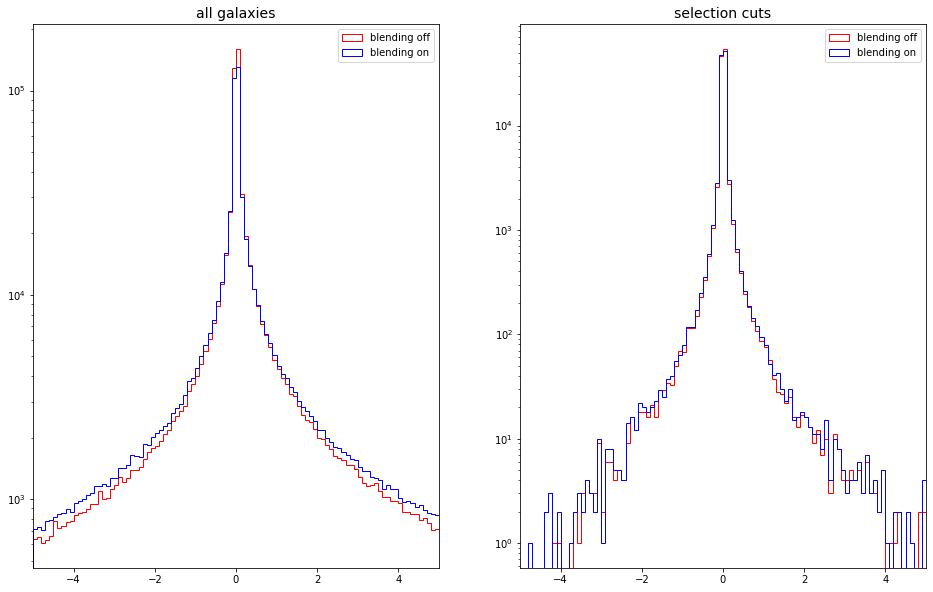

In [22]:
cat1 = cats[-1]
cat2 = fcats[-1]

fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(16,10))
ax1,ax2 = axs.flatten()

ax1.hist(cat1['bias_g1'], histtype='step', range=[-5,5], bins=100, label='blending off', color='r')
ax1.hist(cat1['bias_g1_grp'], histtype='step', range=[-5,5], bins=100, label='blending on', color='b');
ax1.legend()
ax1.set_xlim(-5,5)
ax1.set_yscale("log")
ax1.set_title("all galaxies", fontsize=14)

ax2.hist(cat2['bias_g1'], histtype='step', range=[-5,5], bins=100, label='blending off', color='r')
ax2.hist(cat2['bias_g1_grp'], histtype='step', range=[-5,5], bins=100, label='blending on', color='b');
ax2.legend()
ax2.set_xlim(-5,5)
ax2.set_yscale("log")
ax2.set_title("selection cuts", fontsize=14)

## paper 

(-1, 1)

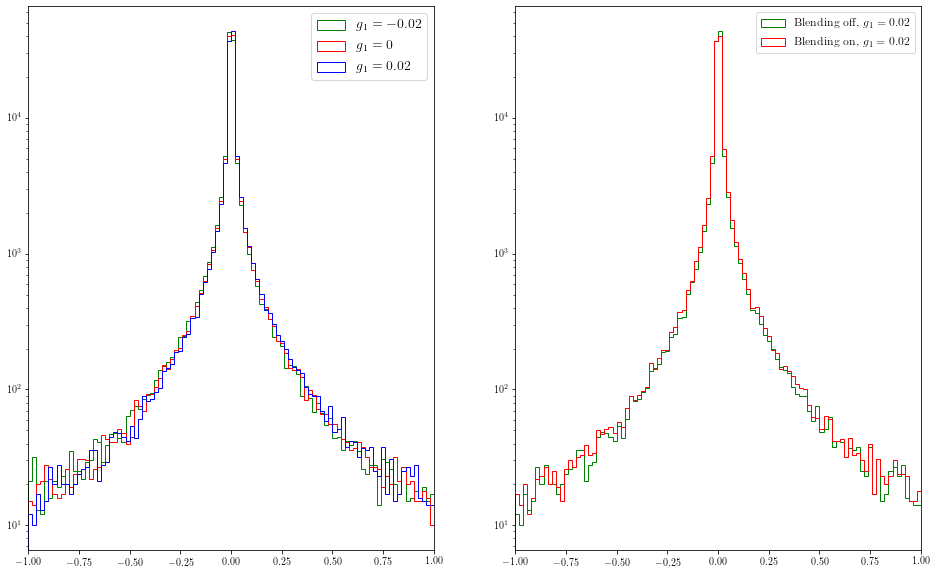

In [72]:
plt.rc('text', usetex=True)

fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(16,10))
ax1,ax2 = axs.flatten()

ax1.hist(fcats[0]['bias_g1'], histtype='step', range=[-1,1], bins=100, label='$g_{1}=-0.02$', color='g');
ax1.hist(fcats[4]['bias_g1'], histtype='step', range=[-1,1], bins=100, label='$g_{1}=0$', color='r');
ax1.hist(fcats[-1]['bias_g1'], histtype='step', range=[-1,1], bins=100, label='$g_{1}=0.02$', color='b');
ax1.set_yscale("log")
ax1.legend(prop={'size':14})
ax1.set_xlim(-1,1)

ax2.hist(fcats[-1]['bias_g1'], histtype='step', range=[-1,1], bins=100, label='\\rm Blending off, $g_{1}=0.02$', color='g');
ax2.hist(fcats[-1]['bias_g1_grp'], histtype='step', range=[-1,1], bins=100, label='\\rm Blending on, $g_{1}=0.02$', color='r');
ax2.set_yscale("log")
ax2.legend(prop={'size':12})
ax2.set_xlim(-1,1)

# Clipped means / weighted means

In [14]:
data_dir = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/WLD/data'

In [15]:
ps = np.linspace(0, 0.5, 51)

In [16]:
def plot_clipped_means(ps, means1, errors1, means2, errors2, wmean1=None, error_wmean1=None,
                       wmean2=None, error_wmean2=None, ylims=None, plot_weighted=False, add_legend=False):
    
    plt.figure(figsize=(8,8))

    #plot errors
    plt.plot(ps, errors1, 'r+', markersize=8, label= 'error of mean g=0')
    plt.plot(ps, errors2, 'bx', markersize=8, label= 'error of means g=0.02')
    
    #plot the means. 
    plot_negpos(ps, means1, 'ro', {'markersize':8}, 'o', dict(markerfacecolor='None', color='r', markersize=8))
    plot_negpos(ps, means2, 'bo', {'markersize':8}, 'o', dict(markerfacecolor='None', color='b', markersize=8))
    
    if plot_weighted:
        #plot weighted means and errors 
        plt.axhline(np.absolute(wmean1), color='r') #negative. 
        plt.axhline(error_wmean1, color='r', linestyle='-.')

        plt.axhline(wmean2, color='b')
        plt.axhline(error_wmean2, color='b', linestyle='-.')

    
    if add_legend:
        add_custom_legend()

    plt.xlabel('quantile', size=20)
    plt.yscale('log')

    plt.ylim(ylims)
    
def plot_negpos(ps, vals, marker_pos, kwargs_pos, marker_neg, kwargs_neg): 
    for p, val in zip(ps, vals):
        if val > 0: 
            plt.plot(p, val, marker_pos, **kwargs_pos)
        else: 
            plt.plot(p, np.absolute(val), marker_neg, **kwargs_neg)
            
def add_custom_legend():
    import matplotlib.lines as mlines

    empty, = plt.plot([], [], 'wo', markersize=7)



    blue_dot, = plt.plot([], [], 'bo', markersize=7)
    blue_dot_nofill, = plt.plot([], [], "o", markerfacecolor='None', color='b', markersize=7)
    red_dot, = plt.plot([],[], 'ro', markersize=7)
    red_dot_nofill,  = plt.plot([],[], "o", markerfacecolor='None', color='r', markersize=7)
    red_plus, = plt.plot([],[], "r+", markersize=7)
    blue_cross, = plt.plot([],[], "bx", markersize=7)

    black_line, = plt.plot([],[], 'k-')

    dotted_line, = plt.plot([],[], 'k-.')

    legend_artists = [empty, empty, (red_dot, blue_dot ), (red_dot_nofill, blue_dot_nofill), 
                      (red_plus, blue_cross), black_line, dotted_line ]
    legend_labels = ["Red: blending off", "Blue: blending on", "Mean > 0", "Mean < 0", "Error on mean", "Weighted mean",
                     "Error on weighted mean"]
    leg = plt.legend(legend_artists, legend_labels, loc='lower left', numpoints=1,
                   handler_map={tuple: HandlerTuple(ndivide=None)})

    for i,text in enumerate(leg.get_texts()):

        if i==0: 
            plt.setp(text, color = 'r')
        elif i==1: 
            plt.setp(text, color = 'b')
        else: 
            break

In [17]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple


def prepare_means_errors(ps, scat, clipped_mean,  N=1000, iso_args=[], grp_args=[]):
    """
    clipped_mean is a function that takes in a dbt, p
    clipped_mean_fnc is a function that only takes in p. 
    """
    
    orig_ids = list(range(len(scat)))
        
    means = [] 
    errors = [] 
    means_grp = [] 
    errors_grp = [] 
    

    
    for p in ps: 
        iso_nargs = [p] + iso_args
        grp_nargs = [p] + grp_args
        print("current p:", p)
        means.append(clipped_mean(orig_ids, scat, *iso_nargs))
        means_grp.append(clipped_mean(orig_ids, scat, *grp_nargs))
        print("calculating errors for p=", p)
        
        errs = weights.get_errors(orig_ids, [scat], clipped_mean, N=N, args=iso_nargs)
        errs_grp = weights.get_errors(orig_ids, [scat], clipped_mean, N=N, args=grp_nargs)
        errors.append(errs[0])
        errors_grp.append(errs_grp[0])
        
    return means, errors, means_grp, errors_grp

## clipped means 

In [47]:
# means, errors, means_grp, errors_grp = prepare_means_errors(ps, fcats[-1], weights.clipped_mean)

In [37]:
# orig_ids = list(range(len(fcats[-1])))
# wmean = weights.wmean(orig_ids, fcats[-1], '1', 'iso', 'component')
# wmean_grp = weights.wmean(orig_ids, fcats[-1], '1', 'grp', 'component')

# err_wmean = weights.get_errors(orig_ids, [fcats[-1]], weights.wmean, N=1000, args=['1', 'iso', 'component'])[0]
# err_wmean_grp = weights.get_errors(orig_ids, [fcats[-1]], weights.wmean, N=1000, args=['1', 'grp', 'component'])[0]

In [48]:
# pickle.dump((means, errors, means_grp, errors_grp, wmean, wmean_grp, err_wmean, err_wmean_grp), 
#             open(os.path.join(data_dir, "fcats", "errors1.p"), 'wb') )
means, errors, means_grp, errors_grp, wmean, wmean_grp, err_wmean, err_wmean_grp = pickle.load(
open(os.path.join(data_dir, "fcats", "errors1.p"), 'rb'), encoding='latin1')

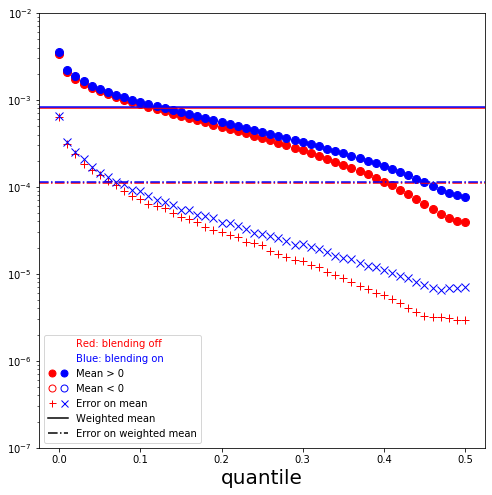

In [52]:
plot_clipped_means(ps, means, errors, means_grp, errors_grp, wmean, err_wmean, 
                   wmean_grp, err_wmean_grp, ylims=[1e-7,1e-2], plot_weighted=True, add_legend=True)

## clipped weighted mean

In [18]:
#clipped weighted mean.
ps_small = np.linspace(0, 0.5, 26)
cwmeans, cwerrors, cwmeans_grp, cwerrors_grps = prepare_means_errors(ps_small, fcats[-1], weights.clipped_weighted_mean, N=500, 
                                                                iso_args=['bias_g1', '1', 'iso', 'component'], 
                                                                grp_args=['bias_g1_grp', '1', 'grp', 'component'])

current p: 0.0
calculating errors for p= 0.0
current p: 0.02
calculating errors for p= 0.02
current p: 0.04
calculating errors for p= 0.04
current p: 0.06
calculating errors for p= 0.06
current p: 0.08
calculating errors for p= 0.08
current p: 0.1
calculating errors for p= 0.1
current p: 0.12
calculating errors for p= 0.12
current p: 0.14
calculating errors for p= 0.14
current p: 0.16
calculating errors for p= 0.16
current p: 0.18
calculating errors for p= 0.18
current p: 0.2
calculating errors for p= 0.2
current p: 0.22
calculating errors for p= 0.22
current p: 0.24
calculating errors for p= 0.24
current p: 0.26
calculating errors for p= 0.26
current p: 0.28
calculating errors for p= 0.28
current p: 0.3
calculating errors for p= 0.3
current p: 0.32
calculating errors for p= 0.32
current p: 0.34
calculating errors for p= 0.34
current p: 0.36
calculating errors for p= 0.36
current p: 0.38
calculating errors for p= 0.38
current p: 0.4
calculating errors for p= 0.4
current p: 0.42
calcula

/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/WLD/mycode/weights.py:65: RuntimeWarning: invalid value encountered in float_scalars
  return np.sum(weights*dbt)/np.sum(weights)


calculating errors for p= 0.5


In [20]:
pickle.dump((cwmeans, cwerrors, cwmeans_grp, cwerrors_grps), open(os.path.join(data_dir, "fcats", "cwerrors1.p"), "wb"))

In [ ]:
cwmeans, cwerrors, cwmeans_grp, cwerrors_grps= pickle.load(open(os.path.join(data_dir, "fcats", 
                                                            "cwerrors1.p"), "rb"), encoding='latin1')

In [ ]:
#plot only the ones with applied shear. 
plot_clipped_means(ps_small, cwmeans, cwerrors, cwmeans_grp, cwerrors_grps, ylims=[1e-7,1e-2], 
                   plot_weighted=False, add_legend=False)

# Bias triangle plots 

In [76]:
import corner 
reload(corner)
plt.rc("text", usetex=False)

myrange = [ (-2000, 8000), (-6, 1), (-6e-5, 1e-4), (-6e-5, 1e-4), (-7.5, 5), (-7.5, 5)]

In [77]:
params = ['bias_f', 'bias_s', 'bias_x', 'bias_y', 'bias_g1', 'bias_g2']

biases = np.array([list(fcats[4][param]) for param in params]).T

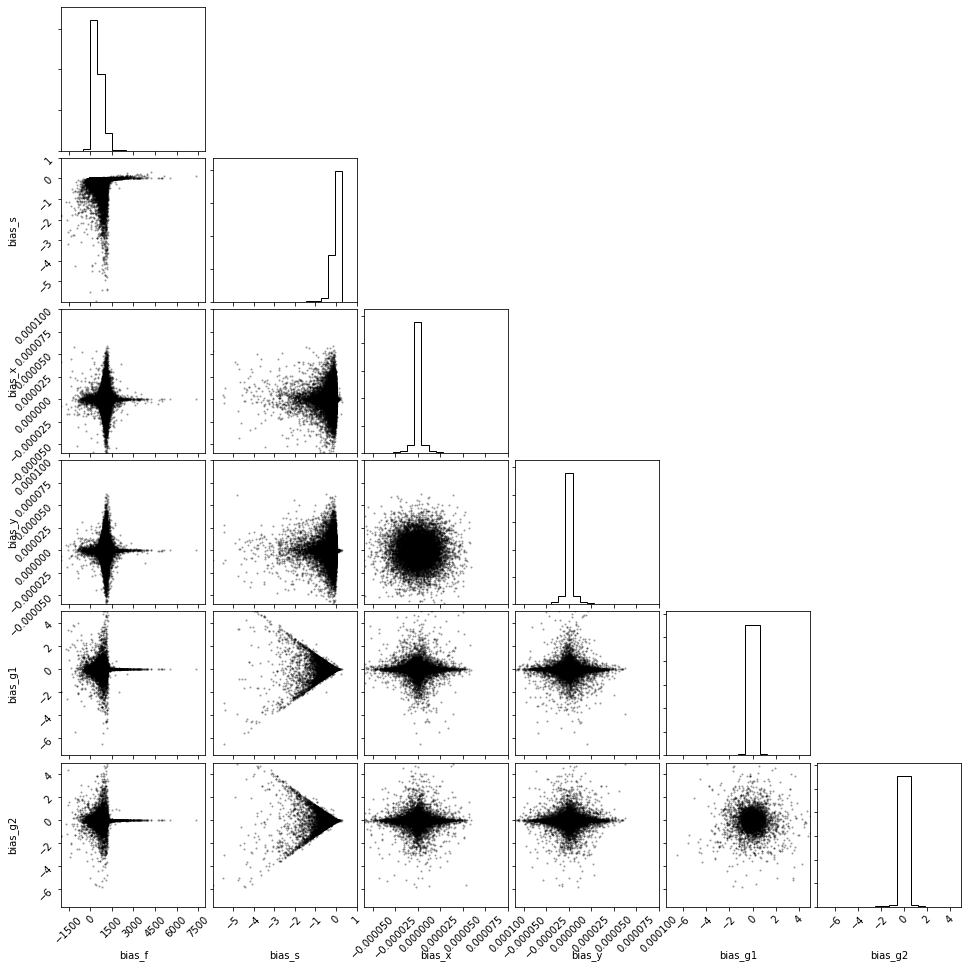

In [78]:
hist2d_kwargs = {'plot_datapoints':True,'plot_density':False,'plot_contours':False, 'quiet':True, 
                     'no_fill_contours':False,'fill_contours':False, 'data_kwargs': {'alpha':0.4, #'markevery':4
                                                                                    }}
figure = corner.corner(biases, labels=params, title_kwargs={"size": 30}, max_n_ticks=7, range=myrange, **hist2d_kwargs);



In [79]:
params = ['bias_f_grp', 'bias_s_grp', 'bias_x_grp', 'bias_y_grp', 'bias_g1_grp', 'bias_g2_grp']

biases = np.array([list(fcats[4][param]) for param in params]).T

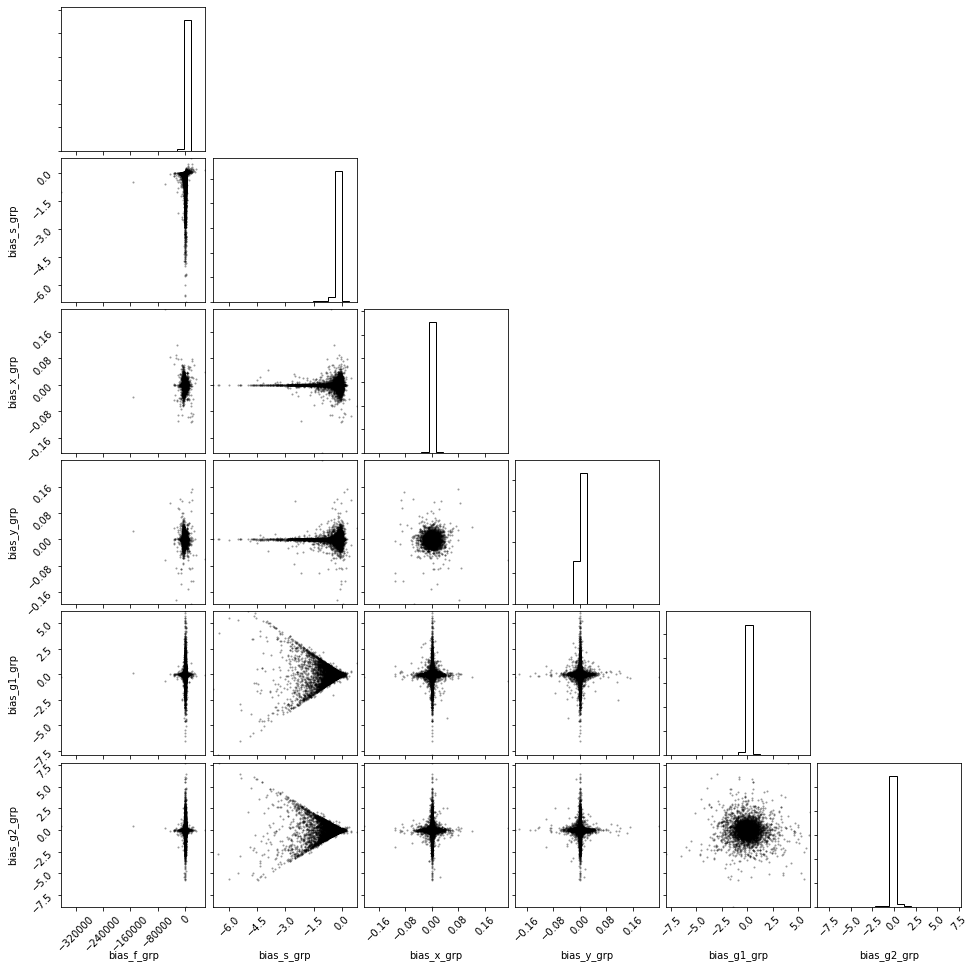

In [81]:
hist2d_kwargs = {'plot_datapoints':True,'plot_density':False,'plot_contours':False, 'quiet':True, 
                     'no_fill_contours':False,'fill_contours':False, 'data_kwargs': {'alpha':0.4, #'markevery':4
                                                                                    }}
figure = corner.corner(biases, labels=params, title_kwargs={"size": 30}, max_n_ticks=7, **hist2d_kwargs);



# Money Plot 

In [13]:
g1s = np.array([-0.02, -0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02])

## all galaxies

### Median 

In [96]:
orig_ids = list(range(len(fcats[0])))

In [97]:
# median_prep = money.prepare_money_plot(g1s, orig_ids, fcats, weights.median_fnc, fit_procedure=money.chi_sq_fit, 
#                          N=int(1e4), model=money.linear_f, args_iso=['1', 'iso'], args_grp=['1', 'grp'])

In [106]:
# pickle.dump(median_prep, open("data/fmedian_prep.p", 'wb'))

In [ ]:
median_prep = pickle.read(open("data/fmedian_prep.p", 'rb'), encoding='latin1')

In [107]:
betas, (values, values_grp), (cov, cov_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = median_prep

In [108]:
# #save boostrapped values too. 
# pickle.dump( (boot_values, boot_values_grp), open("data/fmedian_bootstraps.p", 'wb'))

Results for fits of unblended case: 


 value b0:     1.513e-03
error b0:     4.331e-05
value b1:     3.575e-07
error b1:     1.122e-07
error correlation coefficient: 9.949e-02

Results for fits of blended case: 


 value b0:     3.662e-03
error b0:     9.246e-05
value b1:     -5.557e-06
error b1:     1.757e-06
error correlation coefficient: -1.325e-01


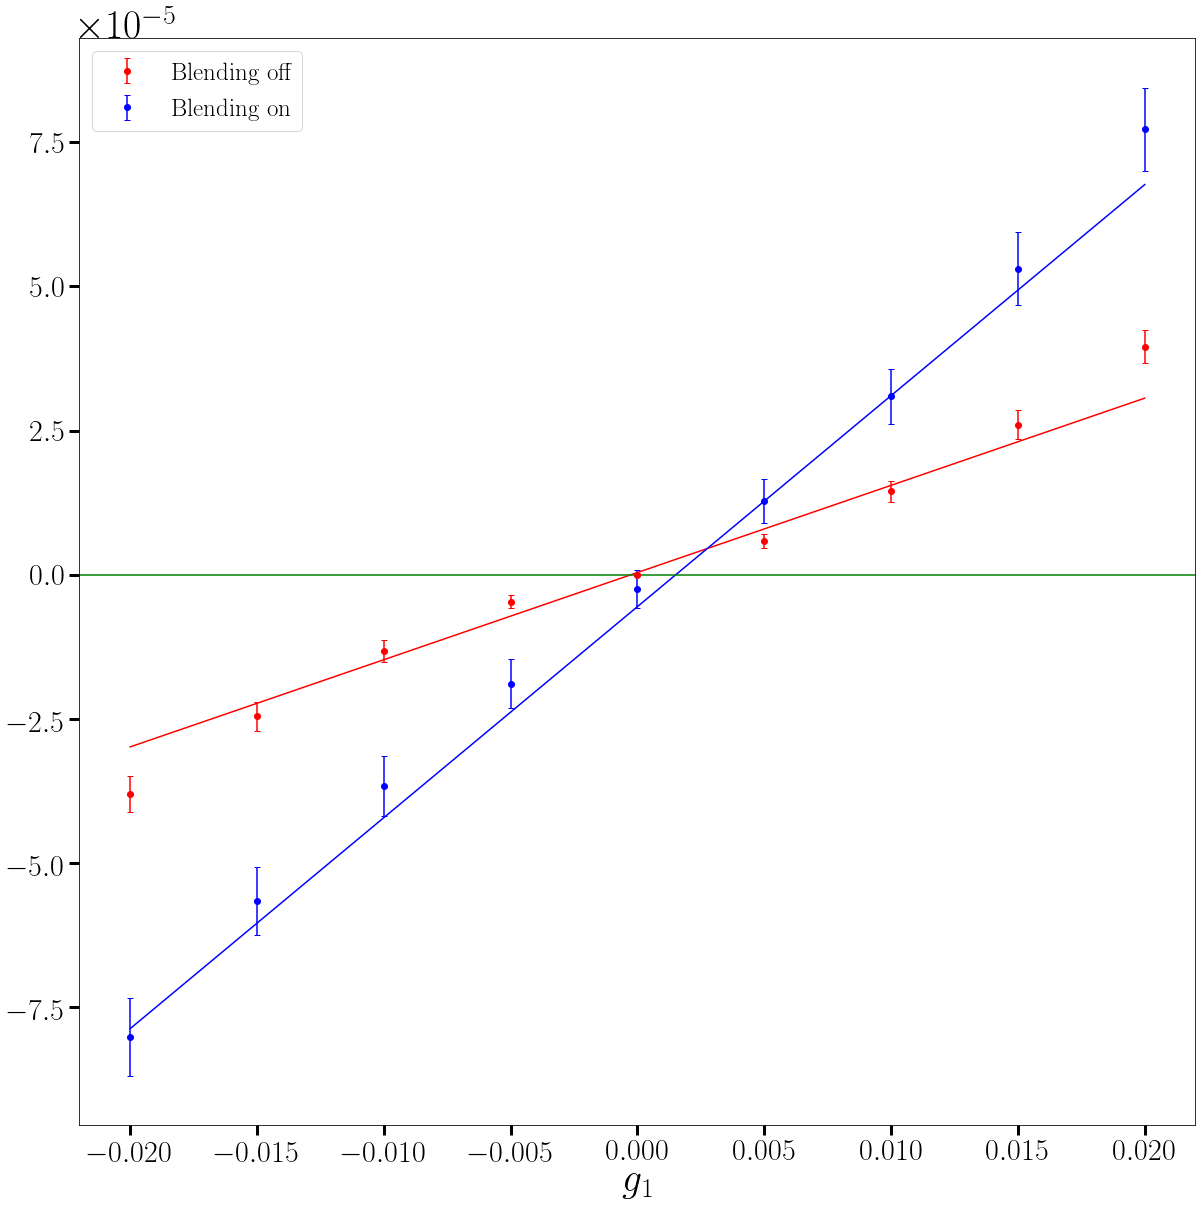

In [102]:
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, betas, ticks1=None, labely1=None)

### Weighted. 

In [87]:
g1s = np.array([-0.02, -0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02])
orig_ids = list(range(len(fcats[0])))

In [88]:
# weights_prep = money.prepare_money_plot(g1s, orig_ids, fcats, weights.wmean, fit_procedure=money.chi_sq_fit, 
#                                         N=int(1e4), model=money.linear_f, args_iso=['1', 'iso', 'component'], 
#                                         args_grp=['1', 'grp', 'component'])

In [105]:
# pickle.dump(weights_prep, open("data/fweights_prep.p", 'wb'))

In [ ]:
weights_prep = pickle.read(open("data/fweights_prep.p", 'rb'), encoding='latin1')

In [109]:
betas, (values, values_grp), (cov, cov_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = weights_prep

In [110]:
# pickle.dump( (boot_values, boot_values_grp), open("data/fweights_bootstraps.p", 'wb'))

Results for fits of unblended case: 


 value b0:     5.303e-02
error b0:     3.157e-04
value b1:     -2.569e-04
error b1:     1.145e-04
error correlation coefficient: 2.980e-03

Results for fits of blended case: 


 value b0:     5.579e-02
error b0:     3.157e-04
value b1:     -2.804e-04
error b1:     1.145e-04
error correlation coefficient: 2.980e-03


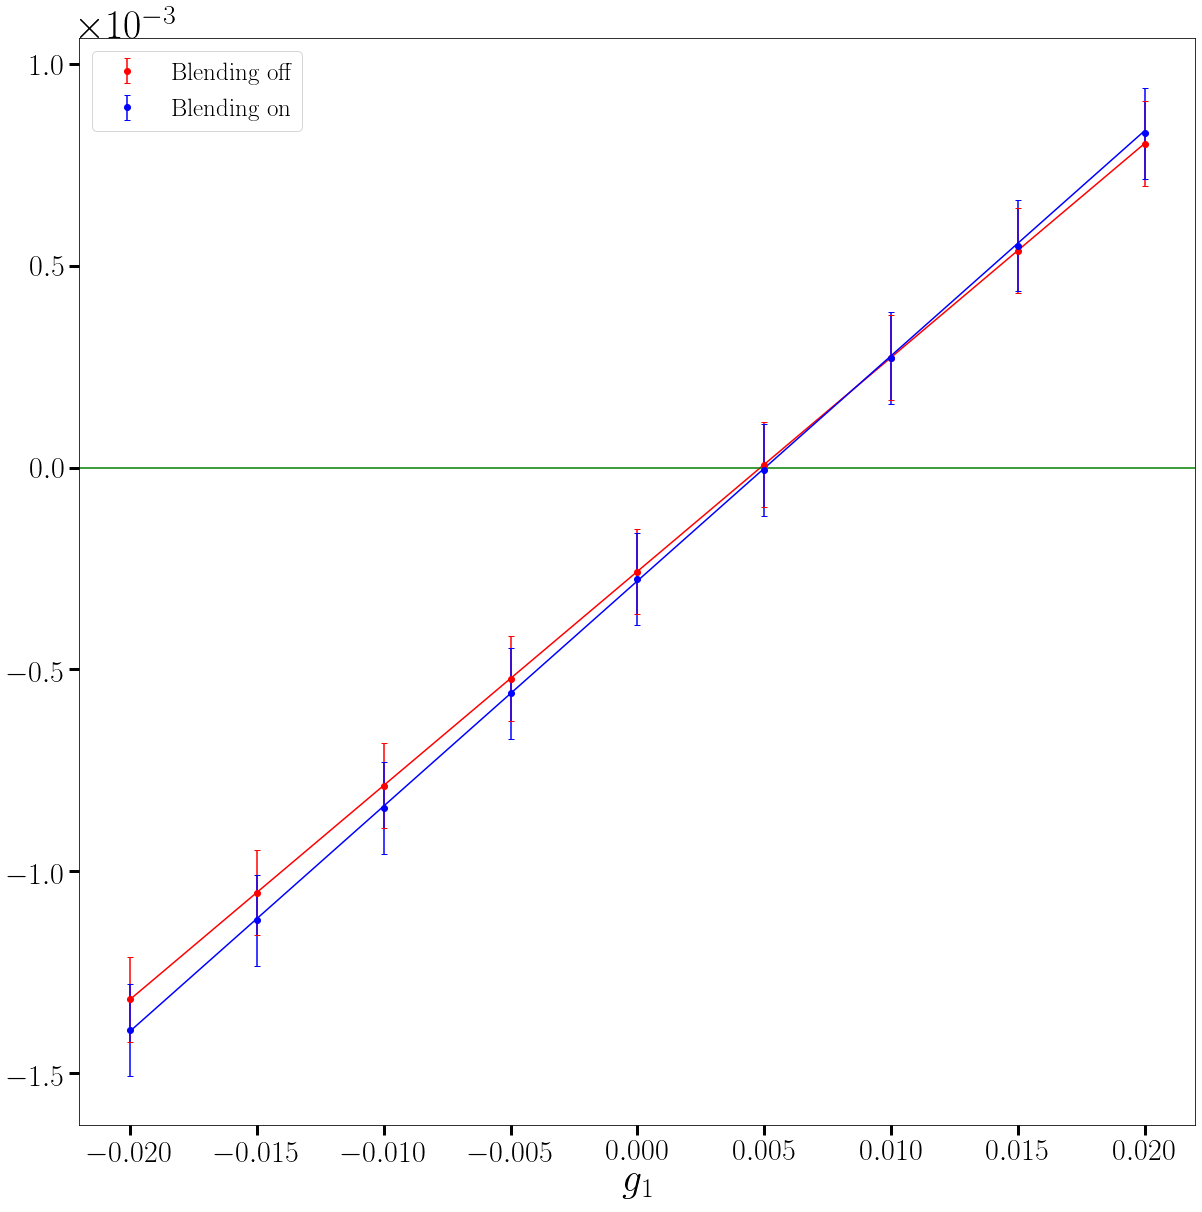

In [104]:
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, betas1, ticks1=None, labely1=None)

#### check boostrapped values 

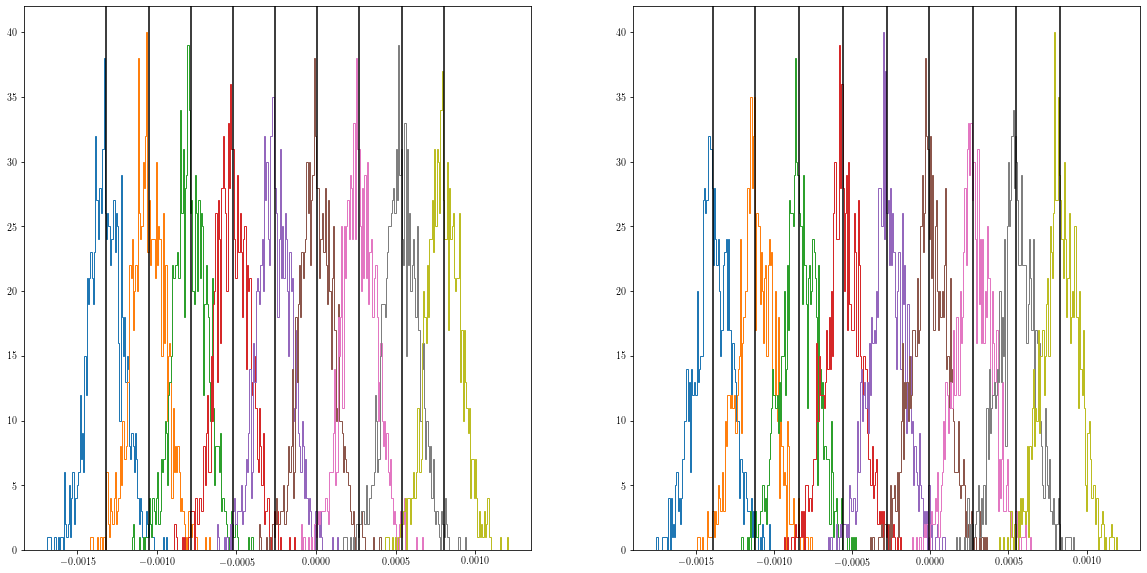

In [76]:
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
ax1,ax2 = axs.flatten()
for val, val_grp, vals, vals_grp  in zip(values, values_grp, boot_values, boot_values_grp): 
    ax1.hist(vals, histtype='step', bins=100)
    ax1.axvline(val,color='k')
    ax2.hist(vals_grp, histtype='step', bins=100)
    ax2.axvline(val_grp, color='k')

## grp size = 1

In [32]:
fcats1 = [cat[cat['grp_size']==1] for cat in fcats]
fcats1 = maps.get_intersection_cats(fcats1)
orig_ids1 = list(range(len(fcats1[0])))
[len(cat) for cat in fcats1]

[15903, 15903, 15903, 15903, 15903, 15903, 15903, 15903, 15903]

### median 

In [33]:
median_prep = money.prepare_money_plot(g1s, orig_ids1, fcats1, weights.median_fnc, fit_procedure=money.chi_sq_fit, 
                         N=int(1e3), model=money.linear_f, args_iso=['1', 'iso'], args_grp=['1', 'grp'])

In [34]:
betas, (values, values_grp), (cov, cov_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = median_prep

Results for fits of unblended case: 


 value b0:     2.843e-02
error b0:     1.071e-03
value b1:     -2.282e-05
error b1:     1.714e-05
error correlation coefficient: -7.664e-02

Results for fits of blended case: 


 value b0:     2.852e-02
error b0:     1.032e-03
value b1:     -2.760e-05
error b1:     1.734e-05
error correlation coefficient: -8.109e-02


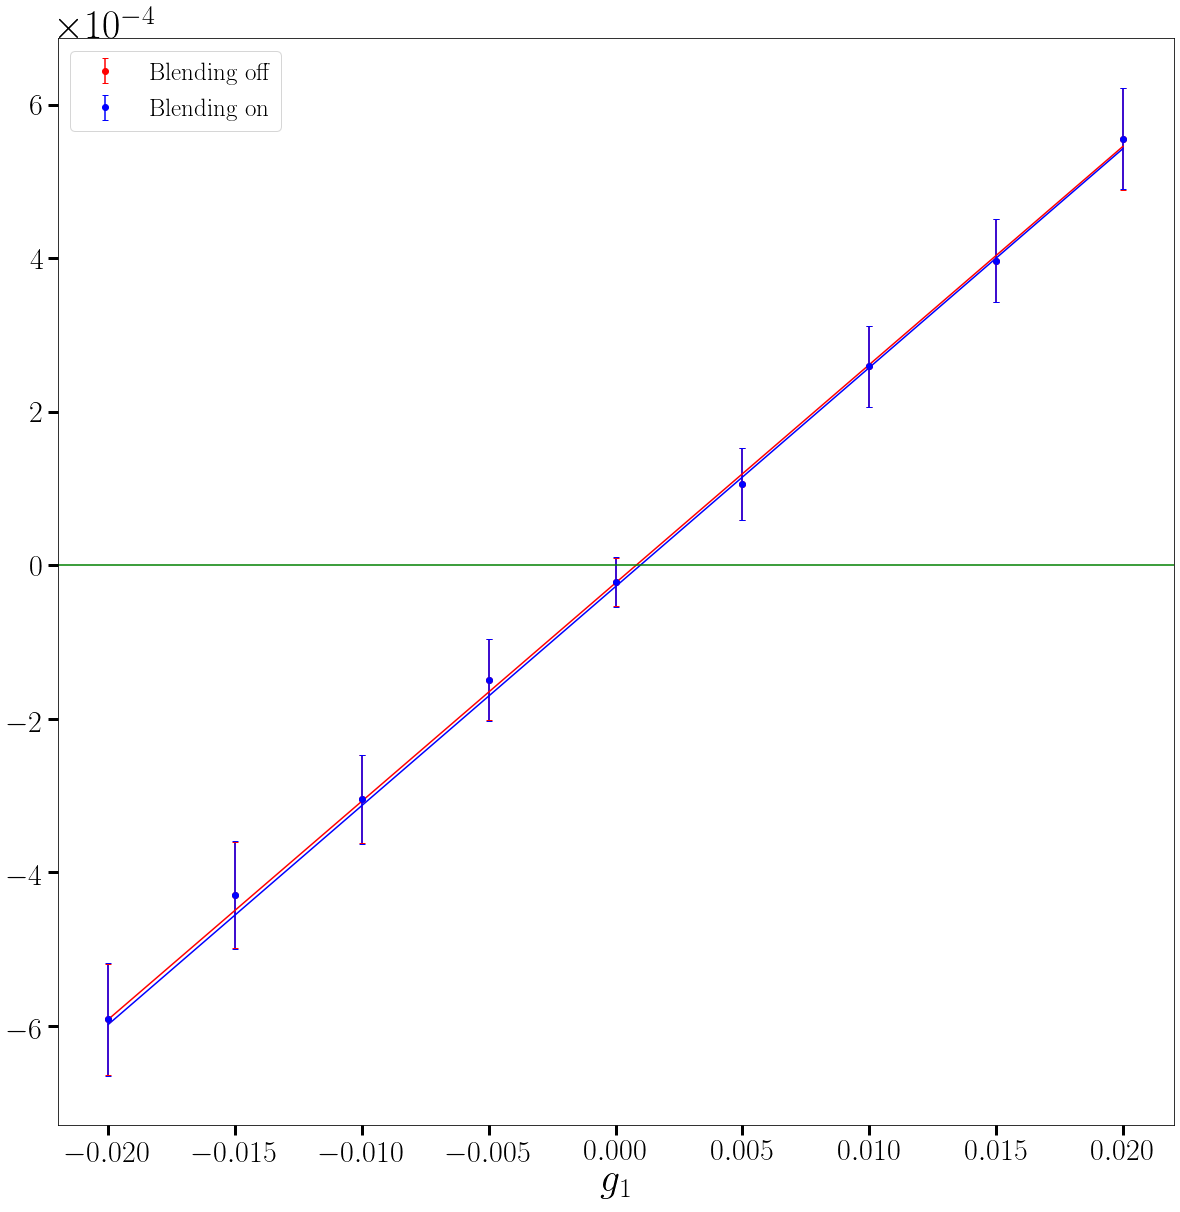

In [35]:
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, betas, ticks1=None, labely1=None)

### weighting 

In [44]:
weights_prep = money.prepare_money_plot(g1s, orig_ids1, fcats1, weights.wmean, fit_procedure=money.chi_sq_fit, 
                                        N=int(1e3), model=money.linear_f, args_iso=['1', 'iso', 'component'], 
                                        args_grp=['1', 'grp', 'component'])

In [45]:
betas, (values, values_grp), (cov, cov_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = weights_prep

Results for fits of unblended case: 


 value b0:     1.062e-01
error b0:     1.197e-03
value b1:     -3.812e-04
error b1:     4.265e-04
error correlation coefficient: -8.378e-02

Results for fits of blended case: 


 value b0:     1.061e-01
error b0:     1.205e-03
value b1:     -2.617e-04
error b1:     4.231e-04
error correlation coefficient: -6.741e-03


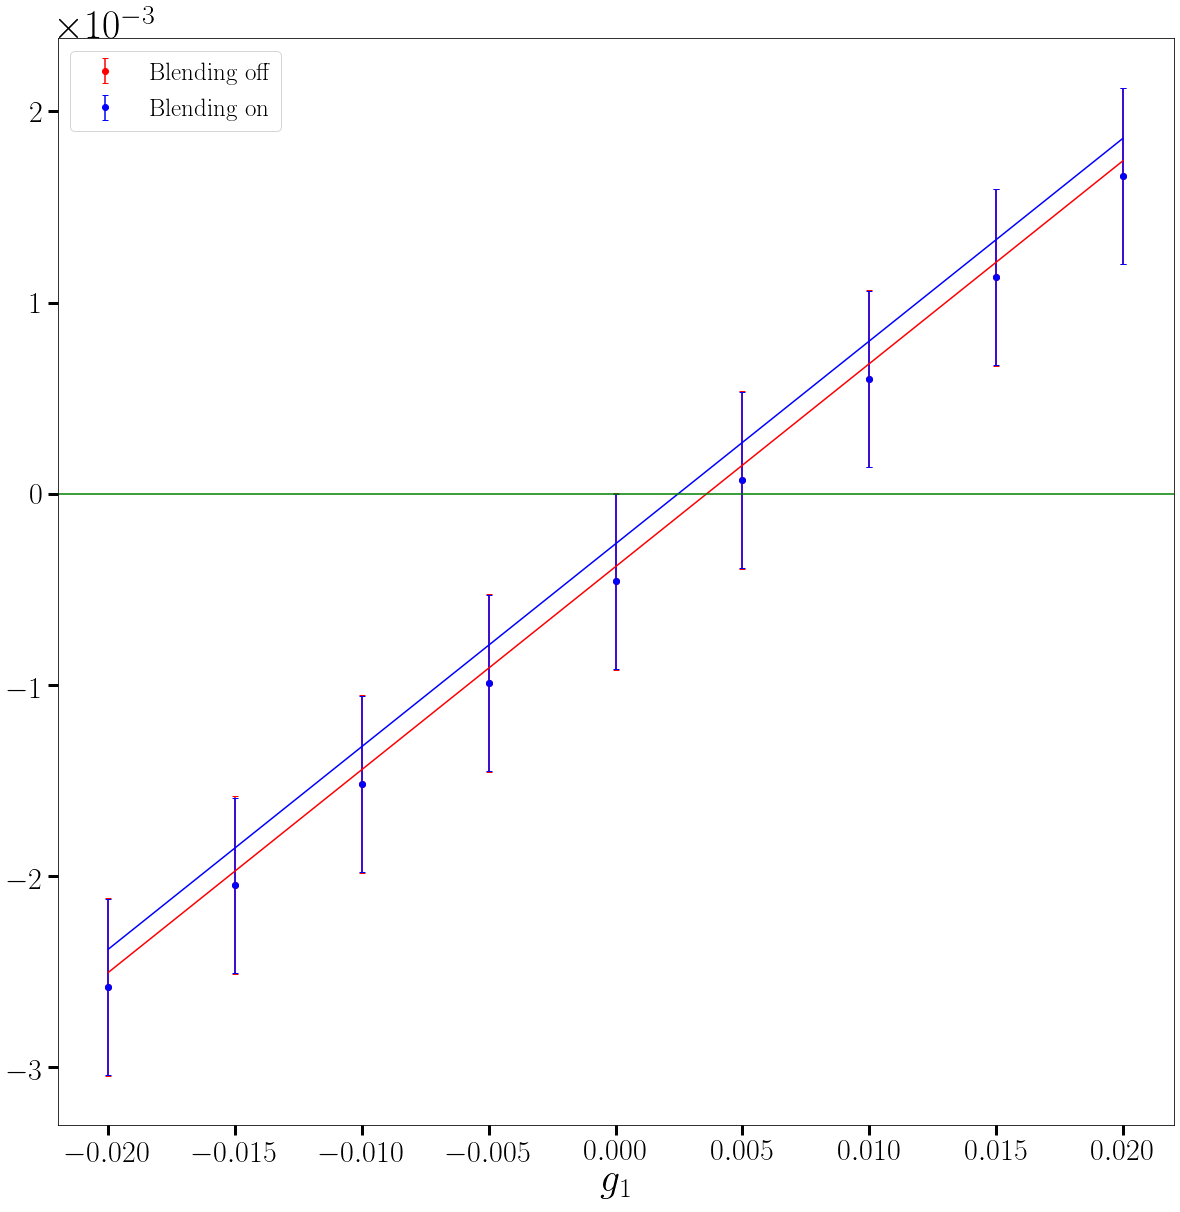

In [46]:
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, betas, ticks1=None, labely1=None)

## group size > 1 

In [39]:
fcats2 = [cat[cat['grp_size']>1] for cat in fcats]
fcats2 = maps.get_intersection_cats(fcats2)
orig_ids2 = list(range(len(fcats2[0])))
[len(cat) for cat in fcats2]

[95896, 95896, 95896, 95896, 95896, 95896, 95896, 95896, 95896]

### medians 

In [40]:
median_prep = money.prepare_money_plot(g1s, orig_ids2, fcats2, weights.median_fnc, fit_procedure=money.chi_sq_fit, 
                         N=int(1e3), model=money.linear_f, args_iso=['1', 'iso'], args_grp=['1', 'grp'])

In [41]:
betas, (values, values_grp), (cov, cov_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = median_prep

Results for fits of unblended case: 


 value b0:     1.056e-03
error b0:     3.407e-05
value b1:     5.765e-07
error b1:     1.184e-07
error correlation coefficient: 1.212e-01

Results for fits of blended case: 


 value b0:     2.729e-03
error b0:     7.496e-05
value b1:     -3.328e-06
error b1:     1.789e-06
error correlation coefficient: -5.453e-02


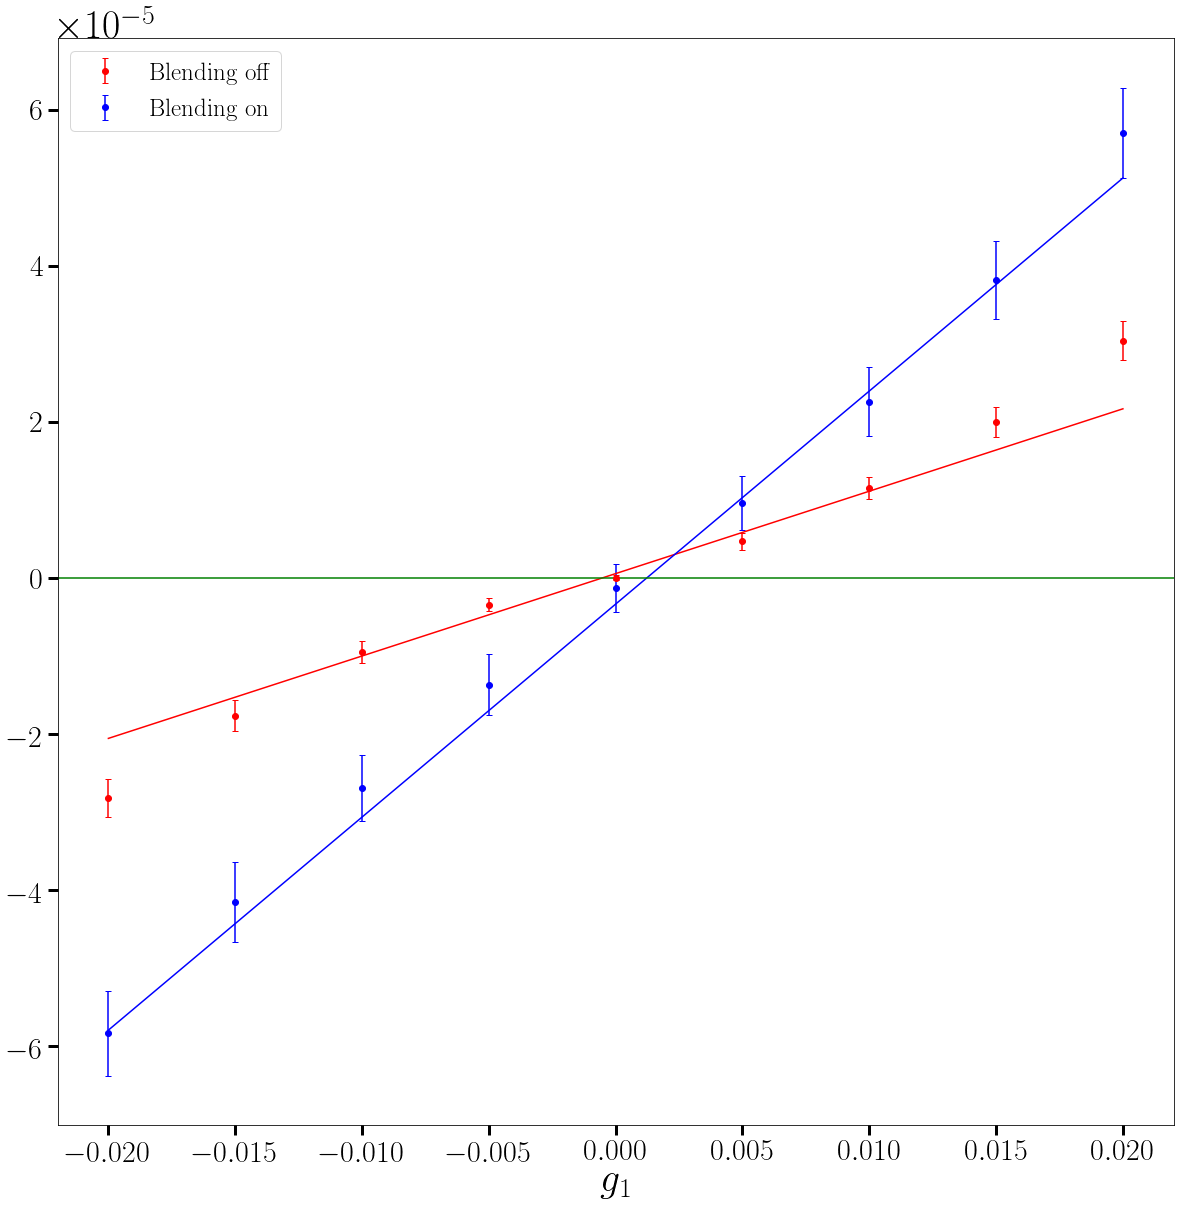

In [42]:
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, betas, ticks1=None, labely1=None)

### weights 

In [47]:
weights_prep = money.prepare_money_plot(g1s, orig_ids2, fcats2, weights.wmean, fit_procedure=money.chi_sq_fit, 
                                        N=int(1e3), model=money.linear_f, args_iso=['1', 'iso', 'component'], 
                                        args_grp=['1', 'grp', 'component'])

In [48]:
betas, (values, values_grp), (cov, cov_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = weights_prep

Results for fits of unblended case: 


 value b0:     4.607e-02
error b0:     2.836e-04
value b1:     -2.290e-04
error b1:     8.787e-05
error correlation coefficient: 3.641e-02

Results for fits of blended case: 


 value b0:     4.911e-02
error b0:     3.373e-04
value b1:     -2.621e-04
error b1:     1.109e-04
error correlation coefficient: 1.143e-03


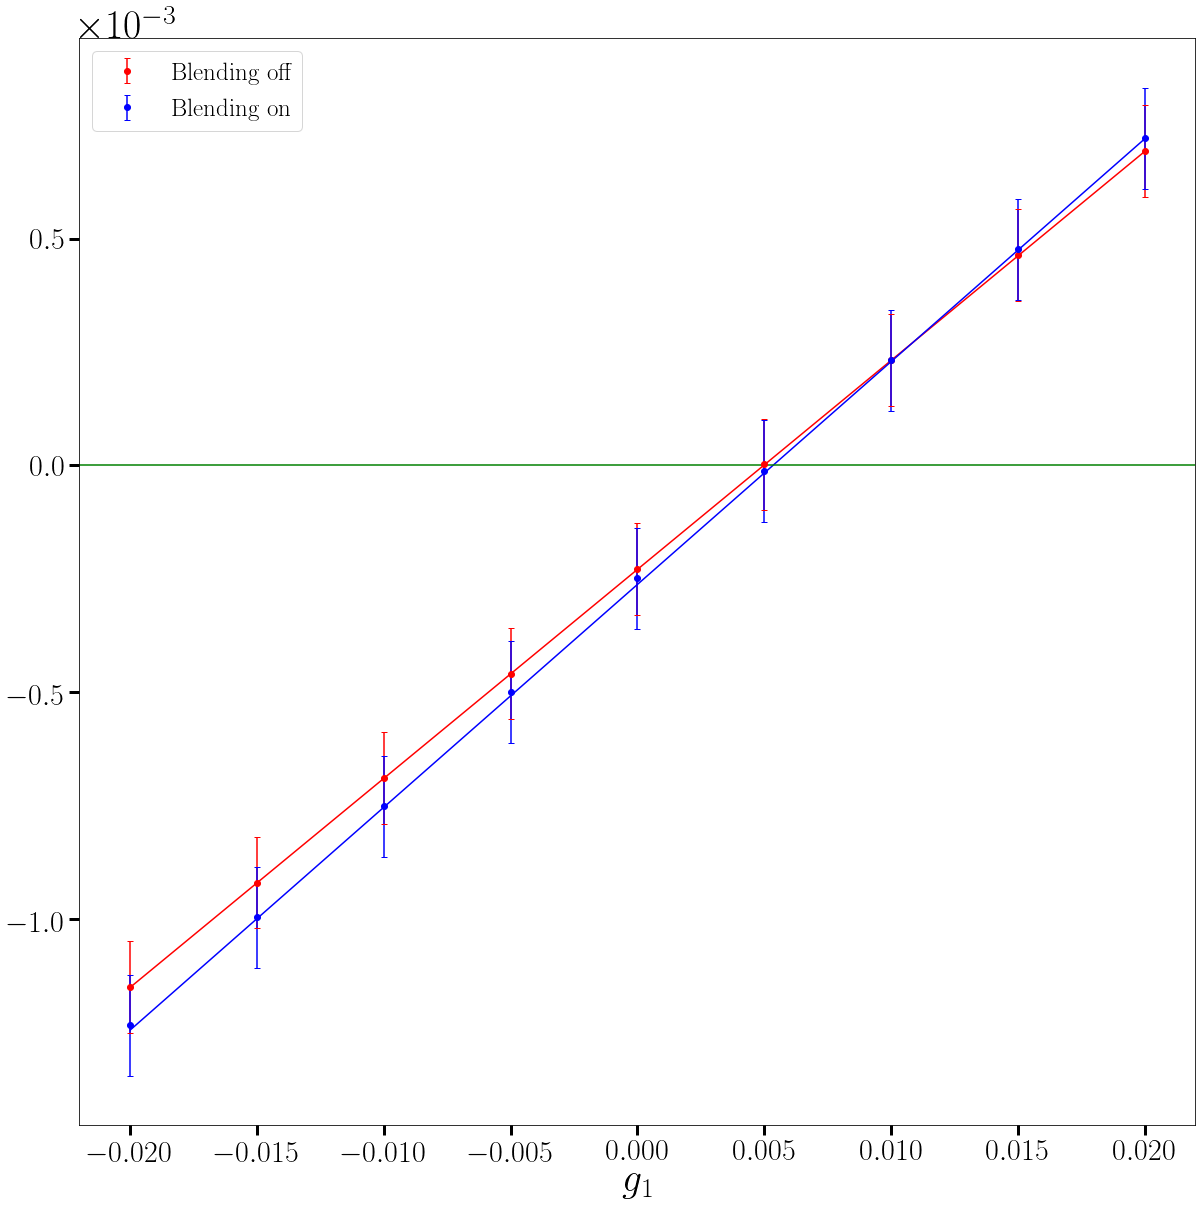

In [49]:
money.make_money_plot(g1s, values, errs, values_grp, errs_grp, betas, ticks1=None, labely1=None)

# Tomographic

In [14]:
from mycode.tomo import tomo_fncs
reload(tomo_fncs);

In [15]:
g1s = np.array([-0.02, -0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02])

In [16]:
tomos = np.linspace(0, 1.2, 7)
print(tomos)

[0.  0.2 0.4 0.6 0.8 1.  1.2]


In [17]:
#obtain tomographic catalogues. 
tomo_cats = tomo_fncs.get_tomographic_cats(fcats, tomos)

In [52]:
#functions we need to make this plot. 

import scipy.odr

def linear_f_odr(B, x):
    '''Linear function y = m*x + b'''
    return B[0]*x + B[1]

def glinear_fit(x,y,yerrs):
    linear = scipy.odr.Model(linear_f_odr)
    mydata = scipy.odr.RealData(x, y, sy=yerrs)
    myodr = scipy.odr.ODR(mydata, linear,beta0=[1.,2.])
    myoutput = myodr.run()
    #myoutput.pprint()
    beta0 = myoutput.beta[0]
    beta1 = myoutput.beta[1]
    real_cov_matrix = myoutput.cov_beta* myoutput.res_var
    
    return beta0, beta1, myoutput.sd_beta[0], myoutput.sd_beta[1], real_cov_matrix[0,1]

def make_tomo_plot(median_preps):

    ms = []
    errs_ms = [] 
    ms_grp = []
    errs_ms_grp = []
    for median_prep in median_preps: 
        betas, (values, values_grp), (cov, cov_grp, corr, corr_grp), (errs, errs_grp), (boot_values, boot_values_grp) = median_prep
        beta0, beta1,beta0_err,beta1_err,beta01_corr = betas[0]
        beta0_grp, beta1_grp,beta0_err_grp,beta1_err_grp,beta01_corr_grp = betas[1]
        
        ms.append(beta0)
        errs_ms.append(beta0_err)
        
        ms_grp.append(beta0_grp)
        errs_ms_grp.append(beta0_err_grp)
    
    
    
    plt.rc('text',usetex=True)
    fig,ax = plt.subplots(figsize=(10,10))
    xs = np.array([np.median(tomo_cats[i][4]['z']) for i in range(len(tomo_cats))])
    
    ax.errorbar(xs, ms, yerr= errs_ms,  color='r', marker='o',linestyle=' ', capsize=2, label= '\\rm{blending off}')
    ax.errorbar(xs, ms_grp, yerr=errs_ms_grp, color='b' , marker='o',linestyle= ' ', capsize=2, label='\\rm{blending on}')
    plt.legend(loc=2, prop={'size':20}) 

    zmax = np.median(tomo_cats[-2][4]['z'])
    
    #do fit and draw the line. 
    #drop the last 'overflow' bin for fitting purposes.  
    beta0_iso, beta1_iso,beta0_err_iso,beta1_err_iso,beta01_cov_iso = glinear_fit(xs[:-1],ms[:-1],errs_ms[:-1])
    beta0_grp, beta1_grp,beta0_err_grp,beta1_err_grp,beta01_cov_grp = glinear_fit(xs[:-1],ms_grp[:-1],errs_ms_grp[:-1])

    get_line = lambda x,m,b: m*x + b 
    y_line_iso= get_line(xs,beta0_iso,beta1_iso)
    y_line_grp= get_line(xs,beta0_grp,beta1_grp)

    #do not plot it all the way to the last bin.
    ax.plot(xs[:-1],y_line_iso[:-1], color='red')
    ax.plot(xs[:-1],y_line_grp[:-1], color='blue')

    #plot the last bin dashed 
    ax.plot(xs[-2:],y_line_iso[-2:], color='red', linestyle='dashed')
    ax.plot(xs[-2:],y_line_grp[-2:], color='blue', linestyle='dashed')


    ax.set_xlabel('$z$', size=26)
    ax.set_ylabel('$m \\; [10^{-2}]$', size=26)
    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.ticklabel_format(style='sci', axis='y', scilimits=(-0, 0))
    ax.get_yaxis().get_offset_text().set_size(1)

    m0_iso = zmax * beta0_iso / 2
    m0_err_iso = beta0_err_iso * zmax /2 
    m0_grp = zmax * beta0_grp / 2
    m0_err_grp = beta0_err_grp * zmax /2 


    m_avg_iso = beta1_iso + m0_iso
    m_avg_iso_err = np.sqrt(beta1_err_iso**2 + m0_err_iso**2)
    m_avg_grp = beta1_grp + m0_grp
    m_avg_grp_err = np.sqrt(beta1_err_grp**2 + m0_err_grp**2)

    corr_iso = ((zmax/2) * beta01_cov_iso + (zmax/2)**2 * beta0_err_iso**2) / np.sqrt(((zmax**2 /4)*beta0_err_iso**2) *(beta1_err_iso**2 + zmax*beta01_cov_iso + (zmax**2/4) * beta0_err_iso**2) )
    corr_grp = ((zmax/2) * beta01_cov_grp + (zmax/2)**2 * beta0_err_grp**2) / np.sqrt(((zmax**2 /4)*beta0_err_grp**2) *(beta1_err_grp**2 + zmax*beta01_cov_grp + (zmax**2/4) * beta0_err_grp**2) )


    print()
    print(f"zmax: {zmax:.3g}")
    print(f"m0 (blending off): {m0_iso:.3g}")
    print(f"m0 err (blending off): {m0_err_iso:.3g}")
    print(f"m_avg (blending off): {m_avg_iso:.3g}")
    print(f"m_avg err (blending off): {m_avg_iso_err:.3g}")
    print(f"correlation (blending off): {corr_iso}")
    print()

    print(f"m0 (blending on): {m0_grp:.3g}")
    print(f"m0 err (blending on): {m0_err_grp:.3g}")
    print(f"m_avg (blending on): {m_avg_grp:.3g}")
    print(f"m_avg err (blending on): {m_avg_grp_err:.3g}")
    print(f"correlation (blending on): {corr_grp}")

## median 

In [20]:
median_preps = [] 
for i, cats in enumerate(tomo_cats):
    print(i)
    orig_ids = list(range(len(cats[0])))
    median_preps.append(
        money.prepare_money_plot(g1s, orig_ids, cats, weights.median_fnc, fit_procedure=money.chi_sq_fit, 
                         N=int(1e3), model=money.linear_f, args_iso=['1', 'iso'], args_grp=['1', 'grp'])
    )

0
1
2
3
4
5
6



zmax: 1.1
m0 (blending off): 0.00163
m0 err (blending off): 0.00017
m_avg (blending off): 0.000892
m_avg err (blending off): 0.000273
correlation (blending off): -0.2035886249342772

m0 (blending on): 0.00326
m0 err (blending on): 0.000123
m_avg (blending on): 0.00237
m_avg err (blending on): 0.000198
correlation (blending on): -0.19992463234120647


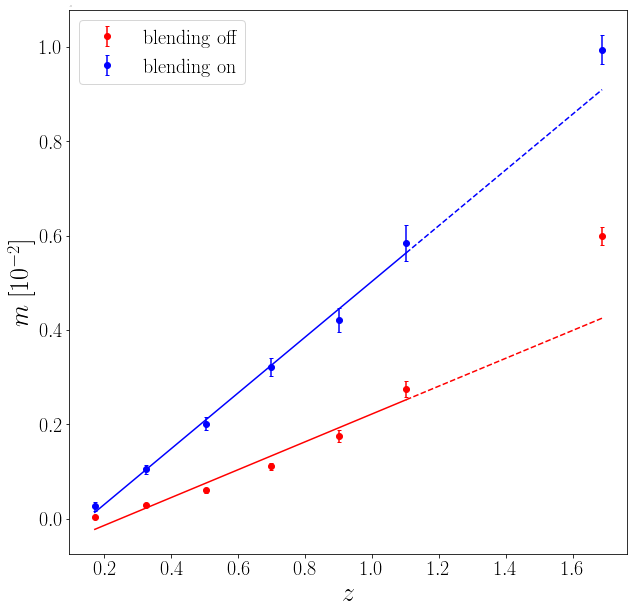

In [39]:
make_tomo_plot(median_preps)

## weighted mean

In [48]:
weights_preps = [] 
for i, cats in enumerate(tomo_cats):
    print(i)
    orig_ids = list(range(len(cats[0])))
    weights_preps.append(
        money.prepare_money_plot(g1s, orig_ids, cats, weights.wmean, fit_procedure=money.chi_sq_fit, 
                         N=int(1e3), model=money.linear_f, args_iso=['1', 'iso', 'component'], 
                                 args_grp=['1', 'grp', 'component'])
    )

0
1
2
3
4
5
6



zmax: 1.1
m0 (blending off): 0.0251
m0 err (blending off): 0.00358
m_avg (blending off): 0.0334
m_avg err (blending off): 0.00574
correlation (blending off): -0.20815767410480135

m0 (blending on): 0.0272
m0 err (blending on): 0.00407
m_avg (blending on): 0.0353
m_avg err (blending on): 0.00651
correlation (blending on): -0.20887960215026224


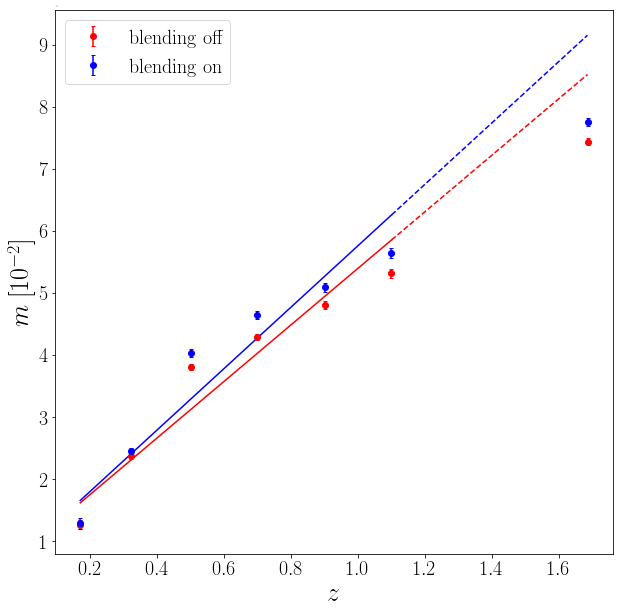

In [53]:
make_tomo_plot(weights_preps)